In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


import xtrack as xt
import xpart as xp
import xwakes as xw
from scipy.signal import spectrogram
from scipy.stats import linregress
from scipy.constants import c

import h5py

In [ ]:
E_k = 71.4e6                         # kinetic energy [eV]
E0  = xp.PROTON_MASS_EV              # proton rest energy [eV]
gamma = 1.0 + E_k / E0
beta  = np.sqrt(1.0 - 1.0 / gamma**2)

R = 26.0                              # mean radius [m]
C = 2*np.pi*R                         # circumference [m]
f_rev = beta * c / C                  # revolution frequency [Hz]

Qx, Qy = 4.31, 3.87
xi = -1.4                             # (natural) chromaticity 
eta = -0.8241                         # slip factor (given)
alpha_p = eta + 1.0 / (gamma**2)      # momentum compaction: η = α_p - 1/γ^2  -> α_p = η + 1/γ^2


h = 2
V_RF = 10.8e3 # [V]
f_RF = f_rev*h
phi_s = np.pi                         # synchronous phase (sign consistent with η<0)

Q_s = np.sqrt(V_RF * eta * h * np.cos(phi_s) / (2*np.pi * beta**2 * (E_k + E0))) # synchrotron tune 

# Bunch / emittances
sigma_z = 10.5                        # bunch length [m] (set to your convention)
epsn_x_geom = 50e-6 * np.pi           
epsn_y_geom = 20e-6 * np.pi
bucket_length = C / h
intensity = 1.5e13                    # protons per bunch

# Resistive wall (round pipe)
resistivity = (1/1.3) * 1e-6          # [Ohm m]
pipe_radius = 50e-3     # [m]

plane = 'y'
wake_type = 'dipolar'

initial_offset=0


### Simulation 
num_particles = 100000
num_turns = 10000 ###



In [4]:
# Full impedance model

# Resistive wall wakefield 

wake_rw = xw.WakeThickResistiveWall(
    kind=f'{wake_type}_{plane}',
    resistivity=resistivity,
    radius=pipe_radius,
    length=C,
    )


# Resonator wake 
wake_res = wake = xw.WakeResonator(r=500e3*10*beta, q=6.1, f_r=82e3,
    kind=f'{wake_type}_{plane}')

wake_res_2 = xw.WakeResonator(r=255e3*10*beta, q=6.7, f_r=94e3,
    kind=f'{wake_type}_{plane}')

wake_res_3 = xw.WakeResonator(r=318e3*beta, q=4.1, f_r=189e3,
    kind=f'{wake_type}_{plane}')

wake_res_4 = xw.WakeResonator(r=108e3*beta, q=4.3, f_r=184e3,
    kind=f'{wake_type}_{plane}')

wake_res_5 = xw.WakeResonator(r=84e3*beta, q=4.7, f_r=162e3,
    kind=f'{wake_type}_{plane}')


time_array = np.concatenate(([0], np.geomspace(1e-15, 1e-2, 100000))) #wakefield calculation
zeta_array = time_array * beta * c

# Make wake table RW 
wake_rw_vs_zeta = wake_rw.components[0].function_vs_zeta(zeta_array, beta0=beta, dzeta=1e-6)
wake_rw_vs_t = wake_rw.components[0].function_vs_t(time_array, beta0=beta, dt=1e-6/beta/c)
wake_rw_df = pd.DataFrame({'time':time_array, 'dipole_y': wake_rw_vs_t*beta}) # beta corrected  

# Add the zero at the beginning of the RW wake
wake_rw_df.loc[0] = 0, 0
print(wake_rw_df)


# Make wake table Res 
wake_res_vs_zeta = wake_res.components[0].function_vs_zeta(zeta_array, beta0=beta, dzeta=1e-6)
wake_res_vs_t = wake_res.components[0].function_vs_t(time_array, beta0=beta, dt=1e-6/beta/c)
wake_res_df = pd.DataFrame({'time':time_array, 'dipole_y': wake_res_vs_t*0.8}) 
# Add the zero at the beginning of the RW wake
wake_res_df.loc[0] = 0, 0

# 2nd res
wake_res_vs_zeta2 = wake_res_2.components[0].function_vs_zeta(zeta_array, beta0=beta, dzeta=1e-6)
wake_res_vs_t2 = wake_res_2.components[0].function_vs_t(time_array, beta0=beta, dt=1e-6/beta/c)
wake_res_df2 = pd.DataFrame({'time':time_array, 'dipole_y': wake_res_vs_t2*1.5}) 
# Add the zero at the beginning of the RW wake
wake_res_df2.loc[0] = 0, 0

#3rd
# Make wake table Res 
wake_res_vs_zeta3 = wake_res_3.components[0].function_vs_zeta(zeta_array, beta0=beta, dzeta=1e-6)
wake_res_vs_t3 = wake_res_3.components[0].function_vs_t(time_array, beta0=beta, dt=1e-6/beta/c)
wake_res_df3 = pd.DataFrame({'time':time_array, 'dipole_y': wake_res_vs_t3*1.5}) 

# Add the zero at the beginning of the RW wake
wake_res_df3.loc[0] = 0, 0

#4th 
# Make wake table Res 
wake_res_vs_zeta4 = wake_res_4.components[0].function_vs_zeta(zeta_array, beta0=beta, dzeta=1e-6)
wake_res_vs_t4 = wake_res_4.components[0].function_vs_t(time_array, beta0=beta, dt=1e-6/beta/c)
wake_res_df4 = pd.DataFrame({'time':time_array, 'dipole_y': wake_res_vs_t4*0.9}) 

# Add the zero at the beginning of the RW wake
wake_res_df4.loc[0] = 0, 0

#5th
# Make wake table Res 
wake_res_vs_zeta5 = wake_res_5.components[0].function_vs_zeta(zeta_array, beta0=beta, dzeta=1e-6)
wake_res_vs_t5 = wake_res_5.components[0].function_vs_t(time_array, beta0=beta, dt=1e-6/beta/c)
wake_res_df5 = pd.DataFrame({'time':time_array, 'dipole_y': wake_res_vs_t5*2.0}) 

# Add the zero at the beginning of the RW wake
wake_res_df5.loc[0] = 0, 0



# Put the wwakes together

combined_dipole_y = wake_rw_df['dipole_y'].values + wake_res_df['dipole_y'].values + wake_res_df2['dipole_y'].values + wake_res_df3['dipole_y'].values + wake_res_df4['dipole_y'].values + wake_res_df5['dipole_y'].values


# Create combined wake dataframe
wake_combined_df = pd.DataFrame({
    'time': time_array,
    'dipole_y': combined_dipole_y
})

# Configure wake for tracking 

wake_for_tracking = xw.WakeFromTable(table=wake_combined_df, columns=['dipole_y',])


wake_for_tracking.configure_for_tracking(
    zeta_range=(-3 * sigma_z, 3 * sigma_z),
    num_slices=200,
    bunch_spacing_zeta=bucket_length,       # 81.68 meters
    num_turns=200,
    circumference=C,
    #filling_scheme=[1, 1],
)


                time      dipole_y
0       0.000000e+00  0.000000e+00
1       1.000000e-15  8.080335e+14
2       1.000299e-15  8.079126e+14
3       1.000599e-15  8.077917e+14
4       1.000898e-15  8.076708e+14
...              ...           ...
99996   9.988034e-03  2.556756e+08
99997   9.991024e-03  2.556374e+08
99998   9.994015e-03  2.555991e+08
99999   9.997007e-03  2.555609e+08
100000  1.000000e-02  2.555226e+08

[100001 rows x 2 columns]


In [5]:
p0c = np.sqrt(E_k**2 + 2*E_k*E0)  
ref_particle = xt.Particles(mass0=xp.PROTON_MASS_EV, p0c=p0c, q0 =1)

qp_x = xi*Qx
qp_y = xi*Qy

one_turn_map = xt.LineSegmentMap( 
            length=C, betx=R/Qx, bety=R/Qy,# Enevlope of betatron oscillations
            qx=Qx, qy=Qy,# Tunes
            dqx=qp_x, dqy=qp_y, # Chromaticity 
            longitudinal_mode='nonlinear', # RF system with fixed RF voltage and frequency
            voltage_rf=[V_RF], frequency_rf=[f_RF], 
            lag_rf=[phi_s], momentum_compaction_factor= alpha_p
        )


flush_data_every = int(1000)

monitor = xw.CollectiveMonitor(
            base_file_name=f'Qy_scan_{Qy:.3f}',
            monitor_bunches=True,
            monitor_slices=True,
            monitor_particles=False,
            #particle_monitor_mask=particle_monitor_mask,
            flush_data_every=flush_data_every,
            stats_to_store=['mean_y', 'mean_py', 'sigma_y', 'epsn_y', 'num_particles'],
            stats_to_store_particles=['y', 'py'],
            backend='hdf5',
            zeta_range=(-0.3*bucket_length, 0.3*bucket_length),
            num_slices=int(100),
            bunch_spacing_zeta=bucket_length,
            #filling_scheme=[1, 1], #for two bunches
        )

# Elements
elements = [monitor, one_turn_map, wake_for_tracking]

# Create line        
line = xt.Line(elements)
line.particle_ref = ref_particle
line.build_tracker()



# Initialize particles to matched gaussian bunch

# Single bunch
particles = xp.generate_matched_gaussian_bunch(line=line,
                                               num_particles=num_particles,
                                               total_intensity_particles=intensity, ### Here the intensity is changes!!
                                               nemitt_x=epsn_x_geom*beta*gamma, 
                                               nemitt_y=epsn_y_geom*beta*gamma,
                                               sigma_z=sigma_z,
                                               particle_ref=line.particle_ref)
'''
# Multi bunch 
particles = xp.generate_matched_gaussian_multibunch_beam(
    bunch_num_particles=50_000,
    bunch_intensity_particles=intensity,
    nemitt_x=epsn_x_geom*beta*gamma, nemitt_y=epsn_y_geom*beta*gamma,
    sigma_z=sigma_z,
    filling_scheme=np.array([1, 1]),
    bucket_length=bucket_length,
    bunch_spacing_buckets=1,
    circumference=C,
    line=line,
)
'''



particles.y += initial_offset # Apply offset on y to get faster instability

# Track
line.track(particles, num_turns=num_turns, with_progress=True)


Ignoring collective elements in particles generation.


*** Maximum RMS bunch length 12.86552002183504m.
... distance to target bunch length: -1.0395e+01
... distance to target bunch length: 2.0179e+00
... distance to target bunch length: 1.8594e+00
... distance to target bunch length: 1.0856e-01
... distance to target bunch length: -1.7722e-01
... distance to target bunch length: 5.4410e-03
... distance to target bunch length: -1.0962e-05
... distance to target bunch length: 1.4653e-05
--> Bunch length: 10.499989038315741


Ignoring collective elements in particles generation.


--> Emittance: 0.31017206402160535


Tracking:   0%|          | 0/10000 [00:00<?, ?it/s]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


/Users/noasteerenberg/anaconda3/envs/xwakes_env/lib/python3.10/site-packages/xwakes/beam_elements/collective_monitor.py:367: RuntimeWarning: invalid value encountered in sqrt
  val = (np.sqrt(self.slicer.var(mom_str) *


Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking: 100%|██████████| 10000/10000 [08:07<00:00, 20.50it/s]


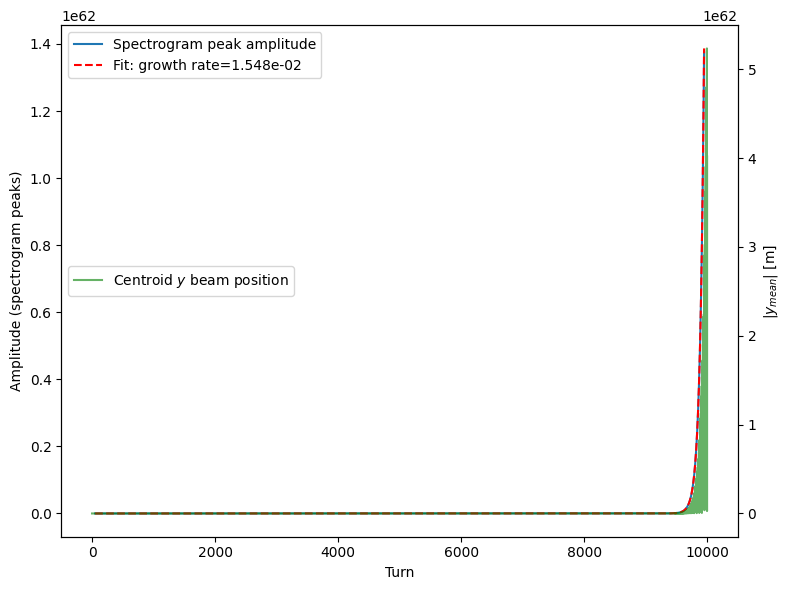

In [6]:
# Data Analysis
# Growth rate using spectogram



with h5py.File(f'Qy_scan_{Qy:.3f}_bunches.h5', 'r') as h5file:
    mean_y = h5file['0']['mean_y'][:]

window_size = 100
overlap = window_size -1

f, t, Sxx = spectrogram( # Sxx contains the magnitude spectrum at each time window 
                        mean_y, 
                       fs = 1.0, 
                       window=('tukey', 0.25), 
                       nperseg = window_size,
                       noverlap = overlap,
                       scaling='spectrum',
                       mode='magnitude')

# Dominant mose per window 
peaks = np.max(Sxx, axis=0)
peaks_freqs=1-f[np.argmax(Sxx, axis=0)]

log_peaks = np.log(peaks)
slope, intercept, r_value, p_value, std_err = linregress(t, log_peaks)

fig, ax = plt.subplots(figsize=(8, 6))


ax.plot(t, peaks, label='Spectrogram peak amplitude')
ax.plot(t, np.exp(slope*t+intercept), 'r--', label=f'Fit: growth rate={slope:.3e}')
ax.set_ylabel('Amplitude (spectrogram peaks)')
ax.set_xlabel('Turn')
ax.legend(loc='upper left')

# Second axis: mean_y
ax2 = ax.twinx()  # Create second y-axis
ax2.plot(np.abs(mean_y), 'g-', alpha=0.6, label='Centroid $y$ beam position')
ax2.set_ylabel('$|y_{mean}|$ [m]')
ax2.legend(loc='center left')


plt.tight_layout()
plt.show()



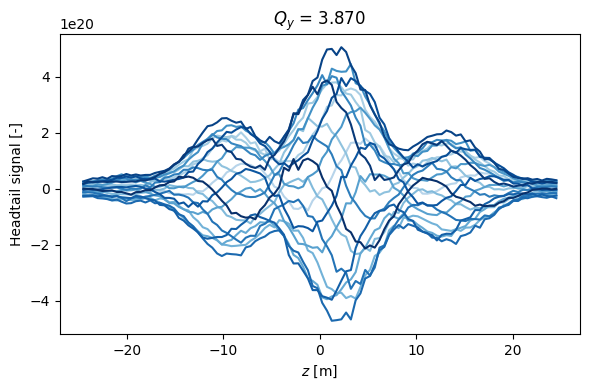

In [7]:
# Plot intrabunch motion

zeta_range = (-0.3 * bucket_length, 0.3 * bucket_length)
num_slices = 100
zeta = np.linspace(zeta_range[0], zeta_range[1], num_slices)

with h5py.File(f'Qy_scan_{Qy:.3f}_slices.h5', 'r') as h5file:
        mean_y = h5file['0']['mean_y'][:]
        num_particles = h5file['0']['num_particles'][:]


turn_to_start_plot = 2000
num_turn_to_plot = 20

turn_range_to_plot = np.arange(turn_to_start_plot, turn_to_start_plot + num_turn_to_plot, 1)

color_range = np.linspace(0.3, 1, num_turn_to_plot)

fig, ax = plt.subplots(figsize=(6, 4))

for ii_turn in turn_range_to_plot:

    ax.plot(zeta, (mean_y * num_particles)[ii_turn, :], color=plt.cm.Blues(color_range[ii_turn-turn_to_start_plot]))

ax.set_xlabel('$z$ [m]')
ax.set_ylabel('Headtail signal [-]')


ax.set_title(f"$Q_y$ = {Qy:.3f}")
fig.tight_layout()

No NaN found for chroma = 3.870


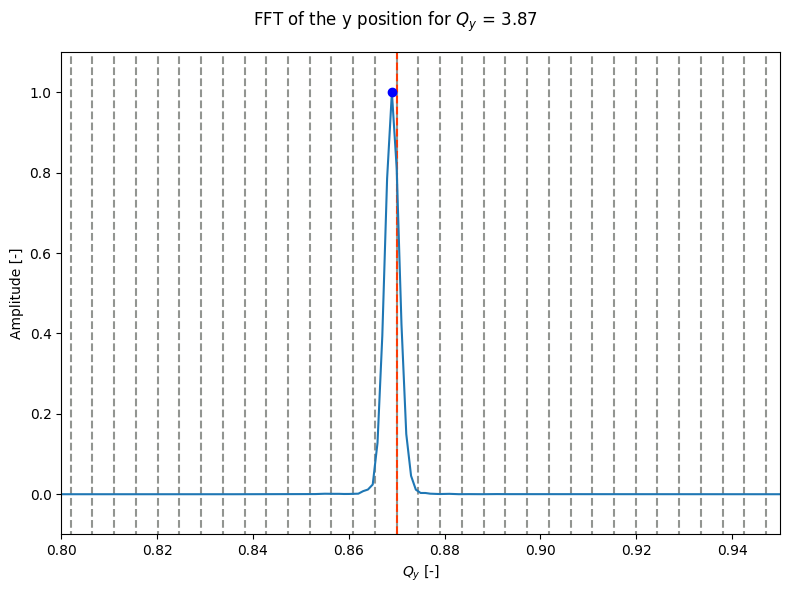

In [8]:
# Plot tune shift


num_turns_fft =1000

Q_y_frac = Qy - int(Qy)

with h5py.File(f'Qy_scan_{Qy:.3f}_bunches.h5', 'r') as h5file:
        mean_y = h5file['0']['mean_y'][:]
        num_particles = h5file['0']['num_particles'][:]


if np.isnan(mean_y).any():
        first_nan_turn = np.argmax(np.isnan(mean_y))-100
        print(f'First NaN at turn {first_nan_turn} for chroma = {Qy:.3f}')
else:
        first_nan_turn = num_turns-100
        print(f'No NaN found for chroma = {Qy:.3f}')

fig, ax = plt.subplots(figsize=(8, 6))

# Show the synchrotron sideband expected position around the tune at zero intensity
ax.vlines([Q_y_frac + ii*Q_s for ii in range(-25, 25)], ymin=-0.9, ymax=1.9, color='xkcd:grey',
          linestyle='--', label='Synchrotron lines',)
ax.vlines([Q_y_frac], ymin=-0.1, ymax=1.1, linestyle='--', color='xkcd:red orange')


window = np.kaiser(num_turns_fft, beta=14)
mean_y = mean_y[:first_nan_turn]
mean_y = mean_y[-num_turns_fft:]
x_values = 1-np.fft.rfftfreq(len(mean_y), d=1.0) # frequency axis, tune shift 
y_values = np.abs(np.fft.rfft(mean_y*window))
ax.plot(x_values, y_values / np.max(y_values),label=f'$Q={x_values[np.argmax(y_values)]:.3f}\ (Q_{{x, 0}}={Q_y_frac})$')
ax.scatter(x_values[np.argmax(y_values)], 1, color='blue', zorder=10)

ax.set_xlabel('$Q_y$ [-]')
ax.set_ylabel('Amplitude [-]')

ax.set_xlim(0.80, 0.95)
ax.set_ylim(-0.1, 1.1)

fig.suptitle(f'FFT of the y position for $Q_y$ = {Qy}')

fig.tight_layout()
